In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import random as rnd

from scipy.sparse import *

from matplotlib import pyplot

In [3]:
urm_path = '../content/data_train.csv'
urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [4]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [5]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [6]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


# Remove empty profiles

In [7]:
# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)



# Let's create the mapping from items indices to original item_ids
item_index_to_original_ID = pd.Series(item_original_ID_to_index.index,index = item_original_ID_to_index.values)



original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

New index for item 125 is 93


,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [8]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


In [9]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [19]:
urm_all = urm_all.tocsr()
urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [ ]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

### Utils for evaluation

In [ ]:
!unzip /content/Recommenders.zip
!unzip /content/Utils.zip

In [10]:
import gc

In [11]:
from Recommenders.Neural.MultVAE_PyTorch_Recommender import MultVAERecommender_PyTorch
from Recommenders.Neural.MultVAERecommender  import MultVAERecommender

In [12]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at,exclude_seen=True)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.10f}, Recall = {:.10f}, MAP = {:.10f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

In [13]:
class Predictor(object):

    def __init__(self, URM, model):
        self.URM = URM
        self.model = model

    def recommend(self, user_id, at=10, exclude_seen=True):
        # Check if user_id is a valid index
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return

        # compute the scores using the fitted model
        scores = self.model._compute_item_score(user_id)[0]

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

### Try to train MultiVAE


In [ ]:
multivae = MultVAERecommender(urm_train)
multivae.fit(anneal_cap= 0.1063276470142029, batch_size= 1000, dropout=0.01, epochs= 100,
                  l2_reg= 0.01, learning_rate= 0.001, total_anneal_steps= 200000)

MultVAERecommender: URM Detected 243 ( 1.9%) users with no interactions.
MultVAERecommender: URM Detected 109 ( 0.5%) items with no interactions.
MultVAERecommender: Using default Temp folder './result_experiments/__Temp_MultVAERecommender_285/'
MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_285/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 5.46 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 8.52 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 13.10 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 16.75 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 19.82 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 22.96 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 26.48 sec
MultVAERecommender: Epoch 8 of 100. Elapsed time 29.54 sec
MultVAERecommender: Epoch 9 of 100. Elapsed time 32.60 sec
MultVAERecommender: Epoch 10 of 100. Elapsed time 35.68 sec
MultVAERecommender: Epo

In [ ]:
# anneal_cap= 0.1063276470142029, batch_size= 1000, dropout=0.01, epochs= 100,
#                   l2_reg= 0.01, learning_rate= 0.001, total_anneal_steps= 200000

model = Predictor(urm_train,multivae)
map_score,prec_score, recall_score = evaluate_algorithm(urm_val,model)
print(f"Map is {map_score}, precision is {prec_score}, recall is {recall_score}")

Recommender results are: Precision = 304.6000000000, Recall = 491.3066461264, MAP = 0.0208107599
Map is 0.020810759884577333, precision is 0.02903717826501422, recall is 0.04683571459736802


In [ ]:
# anneal_cap= 0.1063276470142029, batch_size= 1000, dropout=0.01, epochs= 200,
#                   l2_reg= 0.01, learning_rate= 0.001, total_anneal_steps= 200000

model = Predictor(urm_train,multivae)
map_score,prec_score, recall_score = evaluate_algorithm(urm_val,model)
print(f"Map is {map_score}, precision is {prec_score}, recall is {recall_score}")

Recommender results are: Precision = 304.7000000000, Recall = 486.9767265171, MAP = 0.0211452818
Map is 0.02114528181166186, precision is 0.029046711153479367, recall is 0.04642294819037835


In [ ]:
# anneal_cap= 0.1063276470142029, batch_size= 128, dropout=0.15215292346427248, epochs= 100,
#                   l2_reg= 0.0014502013635276703, learning_rate= 0.00017395673258925492, total_anneal_steps= 389179.15872038255

model = Predictor(urm_train,multivae)
map_score,prec_score, recall_score = evaluate_algorithm(urm_val,model)
print(f"Map is {map_score}, precision is {prec_score}, recall is {recall_score}")

Recommender results are: Precision = 464.8000000000, Recall = 728.0392108090, MAP = 0.0327166560
Map is 0.03271665595147428, precision is 0.044308865586273956, recall is 0.06940316594938092


In [ ]:
# 50 epochs. The rest is default

model = Predictor(urm_train,multivae)
map,prec, recall = evaluate_algorithm(urm_val,model)
print(f"Map is {map}, precision is {prec}, recall is {recall}")

Recommender results are: Precision = 445.2000000000, Recall = 716.2916091744, MAP = 0.0320727105
Map is 0.032072710521556434, precision is 0.042440419447093806, recall is 0.06828328018821976


# K-fold Cross-Validatoin


**Load the similarity matrices of models trained on different train folds**

In [ ]:
from scipy.sparse import save_npz, load_npz

In [ ]:
data_folds = []

for fold_n in range(5):
  fold_urm_train = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/train_noemptyprofiles_fold{fold_n}.npz')
  fold_urm_val = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/val_noemptyprofiles_fold{fold_n}.npz')
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})

print(data_folds)

**Implement  grid search for n_estimators, max_depth and learning_rate hyperparameters**

In [ ]:
from scipy.stats import loguniform
from scipy.stats import uniform

In [ ]:
rnd_anneal_cap = np.array([0.1, 0.3,0.5,0.7,0.9])
rnd_dropout = np.array([0, 0.1,0.3,0.5,0.7])
rnd_l2_reg = np.array(list(set(loguniform.rvs(0.0001,0.1, size=5).astype(float))))
rnd_learning_rate = np.array(list(set(loguniform.rvs(0.00001,0.1, size=5).astype(float))))
rnd_total_anneal_steps = np.array(list(set(loguniform.rvs(50000,1000000, size=5).astype(int))))

print(f"anneal_cap:{rnd_anneal_cap}")
print(f"dropout:{rnd_dropout}")
print(f"l2_reg:{rnd_l2_reg}")
print(f"learning_rate:{rnd_learning_rate}")
print(f"total_anneal_steps:{rnd_total_anneal_steps}")

anneal_cap:[0.1 0.3 0.5 0.7 0.9]
dropout:[0.  0.1 0.3 0.5 0.7]
l2_reg:[0.04658443 0.09216943 0.00014404 0.07625148 0.00826284]
learning_rate:[0.09880998 0.06332294 0.00212678 0.00057622 0.00011892]
total_anneal_steps:[235080 999500 919180 168153 694559]


anneal_cap

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["anneal_cap", "MAP"])
hyperparameter_search_rnd["anneal_cap"] = rnd_anneal_cap
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="anneal_cap")

default_dropout = 0.5
default_l2_reg = 0.01
default_learning_rate = 0.001
default_total_anneal_steps = 200000


for index in hyperparameter_search_rnd.index:

  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the model and train

    multivae = MultVAERecommender(fold['train'])
    multivae.fit(anneal_cap = hyperparameter_search_rnd.loc[index,"anneal_cap"], batch_size= 500, dropout=default_dropout, epochs= 100,
                  l2_reg= default_l2_reg, learning_rate= default_learning_rate, total_anneal_steps= default_total_anneal_steps)

    model = Predictor(fold['train'],multivae)
    map, mp,mr = evaluate_algorithm(fold['val'],model)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for anneal_cap:{hyperparameter_search_rnd.loc[index,"anneal_cap"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
MultVAERecommender: URM Detected 205 ( 1.6%) users with no interactions.
MultVAERecommender: URM Detected 120 ( 0.5%) items with no interactions.
MultVAERecommender: Using default Temp folder './result_experiments/__Temp_MultVAERecommender_324/'
MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_324/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 8.31 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 16.88 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 22.42 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 28.51 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 32.84 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 36.31 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 39.39 sec
MultVAERecommender: Epoch 8 of 100. Elapsed time 44.97 sec
MultVAERecommender: Epoch 9 of 100. Elapsed time 48.02 sec
MultVAERecommender: Epoch 10 of 100. Elapsed time 52.35

   anneal_cap       MAP
0         0.1  0.035925
1         0.3  0.036098
2         0.5  0.036462
3         0.7     0.036
4         0.9  0.036492


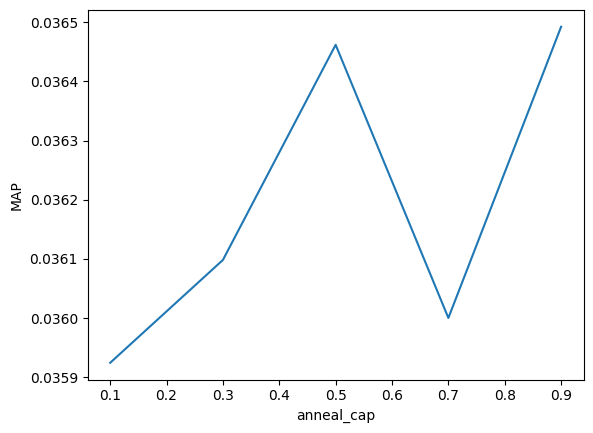

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["anneal_cap"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('anneal_cap')
pyplot.show()

In [ ]:
best_anneal_cap_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_anneal_cap_value

anneal_cap         0.9
MAP           0.036492
Name: 4, dtype: object

l2_reg to consider

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["anneal_cap", "l2_reg", "MAP"])
hyperparameter_search_rnd["l2_reg"] = rnd_l2_reg
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="l2_reg")
hyperparameter_search_rnd["anneal_cap"] = best_anneal_cap_value["anneal_cap"]

hyperparameter_search_rnd.at[4,'MAP'] = 0.03621469152232788
hyperparameter_search_rnd.at[2,'MAP'] = 0.041833216321464944



hyperparameter_search_rnd

,anneal_cap,l2_reg,MAP
2,0.9,0.000144,0.041833
4,0.9,0.008263,0.036215
0,0.9,0.046584,NaN
3,0.9,0.076251,NaN
1,0.9,0.092169,NaN


In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["anneal_cap", "l2_reg", "MAP"])
hyperparameter_search_rnd["l2_reg"] = rnd_l2_reg
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="l2_reg")
hyperparameter_search_rnd["anneal_cap"] = best_anneal_cap_value["anneal_cap"]


default_dropout = 0.5
default_learning_rate = 0.001
default_total_anneal_steps = 200000


for index in hyperparameter_search_rnd.index:

  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the model and train

    multivae = MultVAERecommender(fold['train'])
    multivae.fit(anneal_cap = hyperparameter_search_rnd.loc[index,"anneal_cap"], batch_size= 500, dropout=default_dropout, epochs= 100,
                  l2_reg= hyperparameter_search_rnd.loc[index,"l2_reg"], learning_rate= default_learning_rate,
                 total_anneal_steps= default_total_anneal_steps)

    model = Predictor(fold['train'],multivae)
    map, mp,mr = evaluate_algorithm(fold['val'],model)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for l2_reg:{hyperparameter_search_rnd.loc[index,"l2_reg"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
MultVAERecommender: URM Detected 205 ( 1.6%) users with no interactions.
MultVAERecommender: URM Detected 120 ( 0.5%) items with no interactions.
MultVAERecommender: Using default Temp folder './result_experiments/__Temp_MultVAERecommender_211/'
MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_211/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 7.70 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 11.09 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 14.51 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 17.57 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 21.04 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 23.97 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 28.26 sec
MultVAERecommender: Epoch 8 of 100. Elapsed time 31.59 sec
MultVAERecommender: Epoch 9 of 100. Elapsed time 35.05 sec
MultVAERecommender: Epoch 10 of 100. Elapsed time 38.01

   anneal_cap    l2_reg       MAP
2         0.9  0.000144  0.041833
4         0.9  0.008263  0.036215
0         0.9  0.046584  0.020412
3         0.9  0.076251  0.020312
1         0.9  0.092169  0.019887


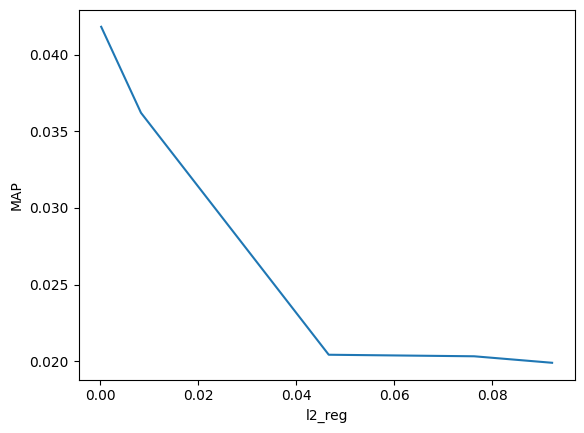

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["l2_reg"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('l2_reg')
pyplot.show()

In [ ]:
best_l2_reg = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_l2_reg

anneal_cap         0.9
l2_reg        0.000144
MAP           0.041833
Name: 2, dtype: object

dropout to consider

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["anneal_cap", "l2_reg","dropout", "MAP"])
hyperparameter_search_rnd["dropout"] = rnd_dropout
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="dropout")
hyperparameter_search_rnd["anneal_cap"] = best_anneal_cap_value["anneal_cap"]
hyperparameter_search_rnd["l2_reg"] = best_l2_reg["l2_reg"]

default_learning_rate = 0.001
default_total_anneal_steps = 200000


for index in hyperparameter_search_rnd.index:

  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the model and train

    multivae = MultVAERecommender(fold['train'])
    multivae.fit(anneal_cap = hyperparameter_search_rnd.loc[index,"anneal_cap"], batch_size= 500,
                 dropout= hyperparameter_search_rnd.loc[index,"dropout"],
                 epochs= 100,l2_reg= hyperparameter_search_rnd.loc[index,"l2_reg"], learning_rate= default_learning_rate,
                 total_anneal_steps= default_total_anneal_steps)

    model = Predictor(fold['train'],multivae)
    map, mp,mr = evaluate_algorithm(fold['val'],model)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for dropout:{hyperparameter_search_rnd.loc[index,"dropout"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
MultVAERecommender: URM Detected 205 ( 1.6%) users with no interactions.
MultVAERecommender: URM Detected 120 ( 0.5%) items with no interactions.
MultVAERecommender: Using default Temp folder './result_experiments/__Temp_MultVAERecommender_211/'
MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_211/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 4.92 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 8.13 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 11.33 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 14.18 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 17.09 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 20.04 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 23.54 sec
MultVAERecommender: Epoch 8 of 100. Elapsed time 26.50 sec
MultVAERecommender: Epoch 9 of 100. Elapsed time 29.41 sec
MultVAERecommender: Epoch 10 of 100. Elapsed time 32.28 

   anneal_cap    l2_reg  dropout       MAP
0         0.9  0.000144      0.0  0.020811
1         0.9  0.000144      0.1  0.050251
2         0.9  0.000144      0.3  0.046444
3         0.9  0.000144      0.5  0.042506
4         0.9  0.000144      0.7  0.038605


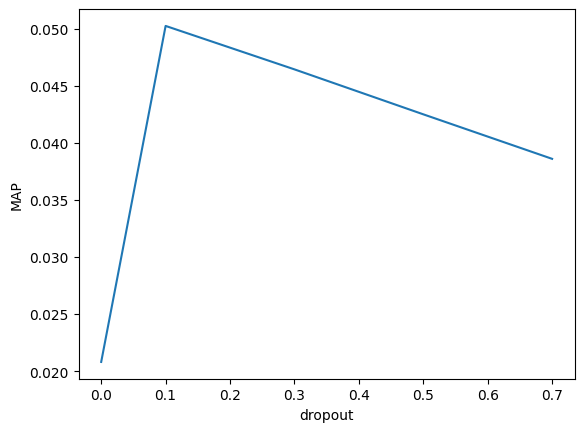

In [ ]:
print(hyperparameter_search_rnd)
pyplot.plot(hyperparameter_search_rnd["dropout"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('dropout')
pyplot.show()

In [ ]:
best_dropout = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_dropout

anneal_cap         0.9
l2_reg        0.000144
dropout            0.1
MAP           0.050251
Name: 1, dtype: object

total_anneal_steps to consider

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["anneal_cap", "l2_reg","dropout","total_anneal_steps", "MAP"])
hyperparameter_search_rnd["total_anneal_steps"] = rnd_total_anneal_steps
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="total_anneal_steps")
hyperparameter_search_rnd["anneal_cap"] = best_anneal_cap_value["anneal_cap"]
hyperparameter_search_rnd["l2_reg"] = best_l2_reg["l2_reg"]
hyperparameter_search_rnd["dropout"] = best_dropout["dropout"]

default_learning_rate = 0.001


for index in hyperparameter_search_rnd.index:

  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the model and train

    multivae = MultVAERecommender(fold['train'])
    multivae.fit(anneal_cap = hyperparameter_search_rnd.loc[index,"anneal_cap"], batch_size= 500,
                 dropout= hyperparameter_search_rnd.loc[index,"dropout"],
                 epochs= 100,l2_reg= hyperparameter_search_rnd.loc[index,"l2_reg"], learning_rate= default_learning_rate,
                 total_anneal_steps= hyperparameter_search_rnd.loc[index,"total_anneal_steps"])

    model = Predictor(fold['train'],multivae)
    map, mp,mr = evaluate_algorithm(fold['val'],model)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for total_anneal_steps:{hyperparameter_search_rnd.loc[index,"total_anneal_steps"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
MultVAERecommender: URM Detected 205 ( 1.6%) users with no interactions.
MultVAERecommender: URM Detected 120 ( 0.5%) items with no interactions.
MultVAERecommender: Using default Temp folder './result_experiments/__Temp_MultVAERecommender_211/'
MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_211/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 5.77 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 8.77 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 11.78 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 14.82 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 18.26 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 21.19 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 24.18 sec
MultVAERecommender: Epoch 8 of 100. Elapsed time 27.17 sec
MultVAERecommender: Epoch 9 of 100. Elapsed time 30.52 sec
MultVAERecommender: Epoch 10 of 100. Elapsed time 33.59 

In [ ]:
print(hyperparameter_search_rnd)
pyplot.plot(hyperparameter_search_rnd["total_anneal_steps"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('total_anneal_steps')
pyplot.show()

In [ ]:
best_total_anneal_steps = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_total_anneal_steps

learning_rate to consider

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["anneal_cap", "l2_reg","dropout","total_anneal_steps","learning_rate", "MAP"])
hyperparameter_search_rnd["learning_rate"] = rnd_learning_rate
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="learning_rate")
hyperparameter_search_rnd["anneal_cap"] = best_anneal_cap_value["anneal_cap"]
hyperparameter_search_rnd["l2_reg"] = best_l2_reg["l2_reg"]
hyperparameter_search_rnd["dropout"] = best_dropout["dropout"]
hyperparameter_search_rnd["total_anneal_steps"] = best_total_anneal_steps["total_anneal_steps"]


for index in hyperparameter_search_rnd.index:

  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the model and train

    multivae = MultVAERecommender(fold['train'])
    multivae.fit(anneal_cap = hyperparameter_search_rnd.loc[index,"anneal_cap"], batch_size= 500,
                 dropout= hyperparameter_search_rnd.loc[index,"dropout"],
                 epochs= 100,l2_reg= hyperparameter_search_rnd.loc[index,"l2_reg"],
                 learning_rate= hyperparameter_search_rnd.loc[index,"learning_rate"],
                 total_anneal_steps= hyperparameter_search_rnd.loc[index,"total_anneal_steps"])

    model = Predictor(fold['train'],multivae)
    map, mp,mr = evaluate_algorithm(fold['val'],model)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for learning_rate:{hyperparameter_search_rnd.loc[index,"learning_rate"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

In [ ]:
print(hyperparameter_search_rnd)
pyplot.plot(hyperparameter_search_rnd["learning_rate"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('learning_rate')
pyplot.show()

In [ ]:
best_learning_rate = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_learning_rate

# Predict for the test data

**Now let's read the data we want to predict for and see if there're overlaps with UserIDs in train data**

In [14]:
urm_pred_path = '/content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_pred_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])
print('Unique user id to predict:', urm_pred_df['UserID'].nunique())

Unique user id to predict: 10882


### Do the predictions, but bear in mind that before feeding the user_id to the model you need to translate it to the model user indices space. Also, you have to translate the recommended item IDs into the original IDs space form the model item IDs space

In [15]:
multivae = MultVAERecommender(urm_all)
multivae.fit(anneal_cap = 0.9, batch_size= 500,
                 dropout= 0.1,
                 epochs= 100,l2_reg= 0.000144,
                 learning_rate = 0.001,
                 total_anneal_steps= 235080)

model = Predictor(urm_all,multivae)

MultVAERecommender: Using default Temp folder './result_experiments/__Temp_MultVAERecommender_193/'
MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_193/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 5.82 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 8.93 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 12.37 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 15.36 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 18.38 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 21.34 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 24.85 sec
MultVAERecommender: Epoch 8 of 100. Elapsed time 27.80 sec
MultVAERecommender: Epoch 9 of 100. Elapsed time 30.79 sec
MultVAERecommender: Epoch 10 of 100. Elapsed time 33.81 sec
MultVAERecommender: Epoch 11 of 100. Elapsed time 37.29 sec
MultVAERecommender: Epoch 12 of 100. Elapsed time 40.27 sec
MultVAERecommender: Epoch 13 of 100. Elapsed time

In [20]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  if userid in user_original_ID_to_index.keys():
   # Map user ID to the index of model user space
    usr_idx = user_original_ID_to_index[userid]
    recomendatoins = model.recommend(usr_idx, at=10,exclude_seen=True)
    # Map item indices from model item space to original item ID
    recomendatoins = [item_index_to_original_ID[idx] for idx in recomendatoins]
  else:
    # If the user isn't present in the given data, recommend TopPop items
    recomendatoins = [2, 4, 1, 7, 3, 6, 8, 9, 15, 20]

  recomendatoins = " ".join(str(item) for item in recomendatoins)
  pred_df.loc[len(pred_df)] = [userid,recomendatoins]

In [21]:
pred_df

,user_id,item_list
0,1,101 3311 36 403 1546 506 977 515 785 2699
1,2,2 3 4 5 6 22 8 13 48 33
2,3,7 2 5 10 59 4 9 1 11 8
3,4,5 3 7 2 1 10 54 9 28 50
4,5,18763 2 51 215 8 14 4 44 1076 434
...,...,...
10877,13020,29 5268 3637 6450 87 51 1490 5092 1203 25
10878,13021,13 3009 36 8 1174 229 32 1 7027 57
10879,13022,809 1668 1411 1446 13 3 2 1674 12 1
10880,13023,828 978 837 129 308 282 1517 3 706 23


In [22]:
pred_df.to_csv('/content/pred_multvae.v1_Max.csv',index=False)